# EfficientDet *Marchantia polymorpha* Gemma Cup Detection

https://medium.com/data-science-at-microsoft/training-efficientdet-on-custom-data-with-pytorch-lightning-using-an-efficientnetv2-backbone-1cdf3bd7921f

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import loaders as lds

## Constants

In [3]:
data_path = Path("..").joinpath("data_in")
images_path = data_path.joinpath("images")

data_path.is_dir(), images_path.is_dir()


(True, True)

## Dataset

### Dataframe

In [4]:
import pandas as pd

df_src = pd.read_csv(str(data_path.joinpath("boxes_final.csv")))
df_src

,filename,x,y,width,height
0,b-1HoJ-Hqz5STrwrZHGBYdjAE3Q.jpg,619.566864,756.123444,65.635284,63.824951
1,b-1HoJ-Hqz5STrwrZHGBYdjAE3Q.jpg,756.218201,591.466797,46.376831,38.321350
2,b-1HoJ-Hqz5STrwrZHGBYdjAE3Q.jpg,900.525146,730.371765,56.363098,56.363037
3,b-38OOnRNVd8OdKdmNYZXXy83E.jpg,631.533997,605.439514,37.705322,36.788940
4,b-38OOnRNVd8OdKdmNYZXXy83E.jpg,899.241516,891.426575,37.705261,35.149414
...,...,...,...,...,...
15849,bzyUXItGRt98Cjh2dk1KeIyqjga8.jpg,761.688232,973.187805,80.784576,62.330414
15850,bzyUXItGRt98Cjh2dk1KeIyqjga8.jpg,874.374115,922.859985,65.104553,77.646912
15851,bzywiC3csPQ0738i9JSahLgzD9wE.jpg,927.864258,701.034180,87.356779,74.697632
15852,bzywiC3csPQ0738i9JSahLgzD9wE.jpg,765.876777,568.327881,90.995261,83.236267


### Split Train, Validation, Test

In [5]:
len(df_src[["filename"]].filename.unique())

3767

In [6]:
from sklearn.model_selection import train_test_split

train_files, test_files = train_test_split(df_src[["filename"]].drop_duplicates(), test_size=0.2)
test_files, val_files = train_test_split(test_files[["filename"]].drop_duplicates(), test_size=0.5)

len(train_files), len(test_files), len(val_files)

(3013, 377, 377)

In [7]:

train = df_src[df_src.filename.isin(train_files.filename.to_list())].sort_values(["filename"])
test = df_src[df_src.filename.isin(test_files.filename.to_list())].sort_values(["filename"])
val = df_src[df_src.filename.isin(val_files.filename.to_list())].sort_values(["filename"])

len(train), len(test), len(val)


(12753, 1604, 1497)

In [8]:
train

,filename,x,y,width,height
0,b-1HoJ-Hqz5STrwrZHGBYdjAE3Q.jpg,619.566864,756.123444,65.635284,63.824951
1,b-1HoJ-Hqz5STrwrZHGBYdjAE3Q.jpg,756.218201,591.466797,46.376831,38.321350
2,b-1HoJ-Hqz5STrwrZHGBYdjAE3Q.jpg,900.525146,730.371765,56.363098,56.363037
13,b-38OOnRNVd8OdKdmNYZXXy83E.jpg,939.846252,695.875488,25.022858,28.276367
12,b-38OOnRNVd8OdKdmNYZXXy83E.jpg,914.323547,613.455078,32.049561,40.362610
...,...,...,...,...,...
15848,bzyUXItGRt98Cjh2dk1KeIyqjga8.jpg,718.044861,668.663391,76.247559,57.094482
15850,bzyUXItGRt98Cjh2dk1KeIyqjga8.jpg,874.374115,922.859985,65.104553,77.646912
15846,bzyUXItGRt98Cjh2dk1KeIyqjga8.jpg,858.230804,700.842346,63.278137,76.711517
15847,bzyUXItGRt98Cjh2dk1KeIyqjga8.jpg,613.711975,739.365784,62.688782,76.064880


### Test Dataset

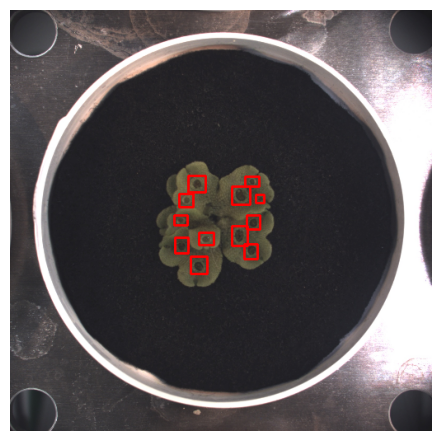

In [63]:
import matplotlib.pyplot as plt

image_size = 512
tst_ds = lds.GemmaDataset(
    train,
    images_path=images_path,
    transform=lds.get_test_image_transform(image_size=image_size),
)

plt.imshow(
    tst_ds.draw_image_with_boxes(filename=train.sample(n=1).filename.to_list()[0])
)
plt.tight_layout()
plt.axis("off")
plt.show()


### Test Transforms

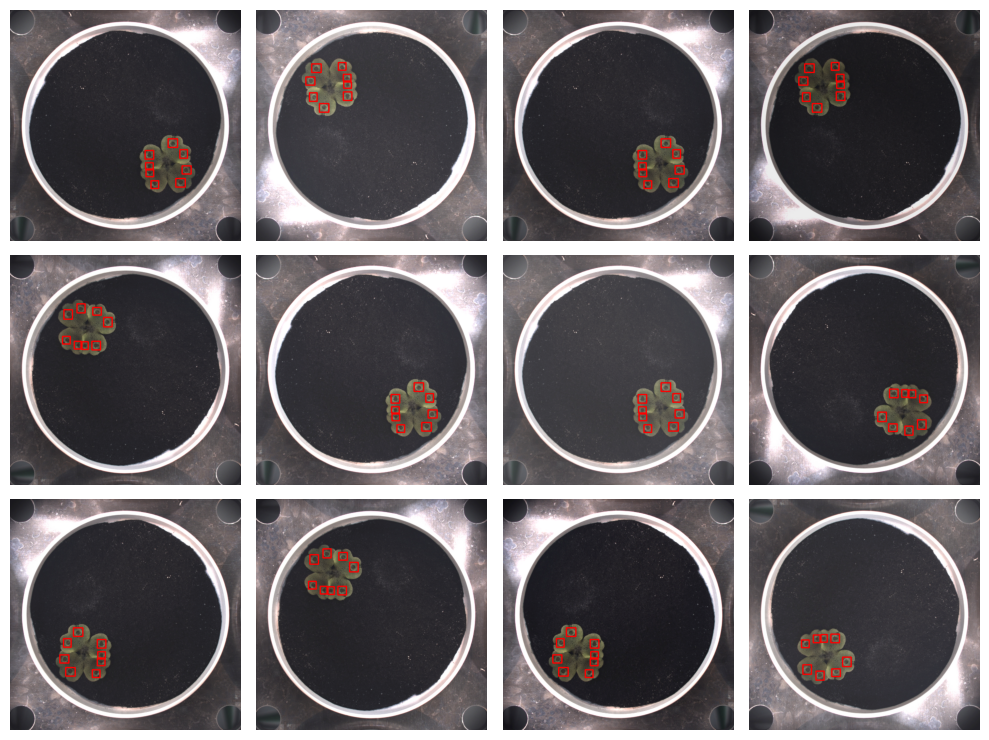

In [64]:
file_name = train.sample(n=1).filename.to_list()[0]

lds.make_patches_grid(
    images=[tst_ds.draw_image_with_boxes(filename=file_name) for _ in range(12)],
    row_count=3,
    col_count=4,
    figsize=(10, 7.5),
)

## Data Loader

In [74]:
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader
import torch


class GemmaCupDataModule(LightningDataModule):
    def __init__(
        self,
        train_dataset_adaptor,
        validation_dataset_adaptor,
        train_transforms=lds.get_train_transform(image_size=image_size),
        valid_transforms=lds.get_valid_transform(image_size=image_size),
        num_workers=0,
        batch_size=8,
    ):
        self.train_ds = train_dataset_adaptor
        self.valid_ds = validation_dataset_adaptor
        self.train_tfms = train_transforms
        self.valid_tfms = valid_transforms
        self.num_workers = num_workers
        self.batch_size = batch_size
        super().__init__()

    def train_dataset(self) -> lds.GemmaDataset:
        return lds.GemmaDataset(
            self.train_ds,
            transform=self.train_tfms,
            images_path=images_path,
        )

    def val_dataset(self) -> lds.GemmaDataset:
        return lds.GemmaDataset(
            self.valid_ds,
            transform=self.valid_tfms,
            images_path=images_path,
        )

    def train_dataloader(self) -> DataLoader:
        train_dataset = self.train_dataset()
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

        return train_loader

    def val_dataloader(self) -> DataLoader:
        valid_dataset = self.val_dataset()
        valid_loader = torch.utils.data.DataLoader(
            valid_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

        return valid_loader

    @staticmethod
    def collate_fn(batch):
        images, targets, image_ids = tuple(zip(*batch))
        images = torch.stack(images)
        images = images.float()

        boxes = [target["bboxes"].float() for target in targets]
        labels = [target["labels"].float() for target in targets]
        img_size = torch.tensor([target["img_size"] for target in targets]).float()
        img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

        annotations = {
            "bbox": boxes,
            "cls": labels,
            "img_size": img_size,
            "img_scale": img_scale,
        }

        return images, annotations, targets, image_ids


## Create model

In [67]:
from effdet.config.model_config import efficientdet_model_param_dict
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from effdet.config.model_config import efficientdet_model_param_dict

In [68]:
print(f'number of configs: {len(efficientdet_model_param_dict)}')

list(efficientdet_model_param_dict.keys())[::3]

number of configs: 47


['efficientdet_d0',
 'efficientdet_d3',
 'efficientdetv2_dt',
 'cspresdet50',
 'cspdarkdet53',
 'mixdet_l',
 'mobiledetv3_large',
 'efficientdet_q2',
 'efficientdet_em',
 'tf_efficientdet_d1',
 'tf_efficientdet_d4',
 'tf_efficientdet_d7',
 'tf_efficientdet_d1_ap',
 'tf_efficientdet_d4_ap',
 'tf_efficientdet_lite1',
 'tf_efficientdet_lite3x']

In [69]:
import timm

In [87]:
timm.list_models('s*')

['sebotnet33ts_256',
 'sedarknet21',
 'sehalonet33ts',
 'selecsls42',
 'selecsls42b',
 'selecsls60',
 'selecsls60b',
 'selecsls84',
 'semnasnet_050',
 'semnasnet_075',
 'semnasnet_100',
 'semnasnet_140',
 'semobilevit_s',
 'senet154',
 'sequencer2d_l',
 'sequencer2d_m',
 'sequencer2d_s',
 'seresnet18',
 'seresnet33ts',
 'seresnet34',
 'seresnet50',
 'seresnet50t',
 'seresnet101',
 'seresnet152',
 'seresnet152d',
 'seresnet200d',
 'seresnet269d',
 'seresnetaa50d',
 'seresnext26d_32x4d',
 'seresnext26t_32x4d',
 'seresnext26tn_32x4d',
 'seresnext26ts',
 'seresnext50_32x4d',
 'seresnext101_32x4d',
 'seresnext101_32x8d',
 'seresnext101d_32x8d',
 'seresnextaa101d_32x8d',
 'skresnet18',
 'skresnet34',
 'skresnet50',
 'skresnet50d',
 'skresnext50_32x4d',
 'spnasnet_100',
 'ssl_resnet18',
 'ssl_resnet50',
 'ssl_resnext50_32x4d',
 'ssl_resnext101_32x4d',
 'ssl_resnext101_32x8d',
 'ssl_resnext101_32x16d',
 'swin_base_patch4_window7_224',
 'swin_base_patch4_window7_224_in22k',
 'swin_base_patch4_w

In [88]:
def create_model(num_classes=1, image_size=512, architecture="tf_efficientnetv2_s"):
    efficientdet_model_param_dict["tf_efficientnetv2_s"] = dict(
        name="tf_efficientnetv2_l",
        backbone_name="tf_efficientnetv2_l",
        backbone_args=dict(drop_path_rate=0.2),
        num_classes=num_classes,
        url="",
    )

    config = get_efficientdet_config(architecture)
    config.update({"num_classes": num_classes})
    config.update({"image_size": (image_size, image_size)})

    print(config)

    net = EfficientDet(config, pretrained_backbone=True)
    net.class_net = HeadNet(
        config,
        num_outputs=config.num_classes,
    )
    return DetBenchTrain(net, config)


### Lightning module

In [89]:
import torch
from pytorch_lightning import LightningModule


class GemmaCupEfficientDetModel(LightningModule):
    def __init__(
        self,
        num_classes=1,
        img_size=512,
        prediction_confidence_threshold=0.2,
        learning_rate=0.0002,
        wbf_iou_threshold=0.44,
        inference_transforms=lds.get_valid_transform(image_size=image_size),
        model_architecture="tf_efficientnetv2_l",
    ):
        super().__init__()
        self.img_size = img_size
        self.model = create_model(
            num_classes, img_size, architecture=model_architecture
        )
        self.prediction_confidence_threshold = prediction_confidence_threshold
        self.lr = learning_rate
        self.wbf_iou_threshold = wbf_iou_threshold
        self.inference_tfms = inference_transforms

    def forward(self, images, targets):
        return self.model(images, targets)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        images, annotations, _, image_ids = batch

        losses = self.model(images, annotations)

        logging_losses = {
            "class_loss": losses["class_loss"].detach(),
            "box_loss": losses["box_loss"].detach(),
        }

        self.log(
            "train_loss",
            losses["loss"],
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        self.log(
            "train_class_loss",
            losses["class_loss"],
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        self.log(
            "train_box_loss",
            losses["box_loss"],
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        return losses["loss"]

    @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        images, annotations, targets, image_ids = batch
        outputs = self.model(images, annotations)

        detections = outputs["detections"]

        batch_predictions = {
            "predictions": detections,
            "targets": targets,
            "image_ids": image_ids,
        }

        logging_losses = {
            "class_loss": outputs["class_loss"].detach(),
            "box_loss": outputs["box_loss"].detach(),
        }

        self.log(
            "valid_loss",
            outputs["loss"],
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
            sync_dist=True,
        )
        self.log(
            "valid_class_loss",
            logging_losses["class_loss"],
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
            sync_dist=True,
        )
        self.log(
            "valid_box_loss",
            logging_losses["box_loss"],
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
            sync_dist=True,
        )

        return {"loss": outputs["loss"], "batch_predictions": batch_predictions}


## Train

In [90]:
dm = GemmaCupDataModule(
    train_dataset_adaptor=train,
    validation_dataset_adaptor=val,
    num_workers=0,
    batch_size=2,
)


In [96]:
model = GemmaCupEfficientDetModel(num_classes=1, img_size=image_size)

{'name': 'tf_efficientnetv2_l', 'backbone_name': 'tf_efficientnetv2_l', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [512, 512], 'num_classes': 1, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 88, 'separable_conv': True, 'apply_resample_bn': True, 'conv_bn_relu_pattern': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detection_points': 5000, 'max_det_per_image': 100, 'url': ''}

In [97]:
model

GemmaCupEfficientDetModel(
  (model): DetBenchTrain(
    (model): EfficientDet(
      (backbone): EfficientNetFeatures(
        (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (blocks): Sequential(
          (0): Sequential(
            (0): ConvBnAct(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn1): BatchNormAct2d(
                32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
                (drop): Identity()
                (act): SiLU(inplace=True)
              )
              (drop_path): Identity()
            )
            (1): ConvBnAct(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn1): BatchNormAct

In [94]:
from pytorch_lightning import Trainer

trainer = Trainer(
    accelerator="gpu",
    max_epochs=5,
    num_sanity_val_steps=1,
)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [95]:
trainer.fit(model, dm)

Missing logger folder: /Users/mavi/Code/python/gemma_cup_detection/notebooks/lightning_logs

  | Name  | Type          | Params
----------------------------------------
0 | model | DetBenchTrain | 116 M 
----------------------------------------
116 M     Trainable params
0         Non-trainable params
116 M     Total params
467.619   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: stack expects each tensor to be equal size, but got [2, 88, 8, 8] at entry 0 and [2, 88, 2, 2] at entry 1